# PROJECT: Course Optimization for Data Science 2022-2023
## Optimization strategies for the "smoothed" quantile regression with (non-)smooth penalties

Author: Alexandre Gramfort

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- Derive mathematically and implement the loss and gradient of a smoothed pinball loss used for quantile regression
- Implement your own solvers for L1 and L2 regularizations with: (Accelerated) Proximal gradient descent, proximal coordinate descent and L-BFGS (only for L2)
- Implement your own scikit-learn estimator for L1 or L2 regularized smoothed-quantile regression model and test it on a real dataset where we will look at prediction invtervals.


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 2nd of January 2023 at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [ ]:
# Change here using YOUR first and last names
fn1 = "guillaume"
ln1 = "philippe"
fn2 = "max"
ln2 = "wu"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_philippe_guillaume_and_wu_max.ipynb


Some imports

In [ ]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt
from numba import njit, vectorize

## Part 1: Smoothed quantile regression model

[Quantile regression](https://en.wikipedia.org/wiki/Quantile_regression) is a supervised learning regression model with target space $\mathcal{Y} = \mathbb{R}$. It is a method widely used in statistics to obtain prediction intervals, and it is very often used in time series forecasting.

We consider observations $x \in \mathbb{R}^{P}$. $P$ is the number of features, and we will denote the $N$ observations available in the training set as $x_1, \dots, x_N$.

We consider a linear model, _i.e.,_ we want to learn the parameters $\theta = (w, b) \in \mathbb{R}^{P}\times \mathbb{R}$ such that the value of $w^\top x + b$ is the $\tau$-quantile of the conditional distribution $y | x$. For example, for $\tau=0.5$, we want to learn the parameters such that the value of $w^\top x + b$ is the *median* of the conditional distribution $y | x$. For $\tau=0.9$, we want to learn the parameters such that the value of $w^\top x + b$ is the *90th percentile* of the conditional distribution $y | x$, meaning that 90% of the observations of $y | x$ are below $w^\top x + b$.

An estimate $\hat{q}$ of the $\tau$-conditional sample quantile is obtained by minimizing the following loss function:
$$
\hat{q} = \arg\min_{q}
    \frac{1}{N} \sum_{i=1}^N
    \left[
            (\tau - 1) \mathbb{1}_{\{y_i < q\}} (y_i - q) + 
            \tau \mathbb{1}_{\{y_i \geq q\}} (y_i - q)
    \right]
$$

The function $\ell_\tau(z) = (\tau - 1) \mathbb{1}_{\{z \leq 0\}} (z) + \tau \mathbb{1}_{\{z \geq 0\}} (z)$ is known as the **pinball loss**. The above loss can then be rewritten as:
$$
\hat{q} = \arg\min_{q}
    \frac{1}{N} \sum_{i=1}^N \ell_\tau(y_i - q) \enspace.
$$
The optimization problem becomes:
$$
\hat{w}, \hat{b} = \arg\min_{w, b} L(w, b)
    \enspace \mathrm{with} \enspace L(w, b) = \frac{1}{N} \sum_{i=1}^N \ell_\tau(y_i - w^\top x_i - b)
$$

Introducing some regularization on the parameter $w$ with parameter $\lambda \ge 0$, the penalized estimation problem is written:

$$
    (\mathcal{P}^{\mathcal{R}}):
	\min_{w \in \mathbb{R}^P, b \in \mathbb{R}} \quad L(w, b) + \lambda \mathcal{R}(w)
$$

where $\mathcal{R}(w)$ can be :
- $\mathcal{R}_1(w) = \|w\|_1 = \sum_{j=1}^P |w_{j}|$, ie. an $\ell_1$ norm
- $\mathcal{R}_2(w) = \|w\|_2^2 = \sum_{j=1}^P w_{j}^2$, ie. a squared $\ell_2$ norm

Here is an implementation of the pinball loss:

In [ ]:
@njit
def pinball(z, tau=0.5):
    """Compute the pinball loss for z and a quantile tau.

    Parameters
    ----------
    z : ndarray, shape (n_samples,)
        The values on which to compute the pinball loss.
    tau : float in [0, 1]
        The quantile.
    
    Returns
    -------
    loss : ndarray, shape (n_samples,)
        The value of the pinball loss for each value of z.
    """
    sign = (z >= 0).astype(z.dtype)
    loss = tau * sign * z - (1 - tau) * (1 - sign) * z
    return loss

#### QUESTION 0

- Plot the pinball loss for tau=0.3, 0.5 and 0.7.

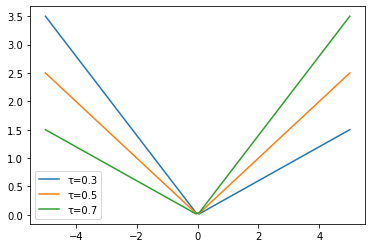

In [ ]:
### TODO
z = np.linspace(-5, 5, 100)
plt.figure()
for tau in [0.3, 0.5, 0.7]:
  plt.plot(z, pinball(z, tau), label=f"τ={tau}")
plt.legend()
plt.show()
### END TODO

#### QUESTION 1:

- Justify that $(\mathcal{P}^{\mathcal{R}_1})$ and $(\mathcal{P}^{\mathcal{R}_2})$ are convex optimization problems.
- Can you readily apply gradient descent or proximal gradient descent to solve these two problems? You will justify your answer by commenting on the smoothness of the objective functions.

**ANSWER 1**

**1.**
Let us prove that $L(w, b)$ and  $\lambda \mathcal{R}(w)$ are both convex functions for $(\mathcal{P}^{\mathcal{R}_1})$ and $(\mathcal{P}^{\mathcal{R}_2})$ : 

*  $L(w, b)$ convexity : Let ($x$,$y$) $\in \mathbb{R}^{2}$ and $\lambda \in [0,1]$. 
  - When $x$ and $y$ have the same sign, the have the following equality (linearity of $\ell\tau$) :
  
    \begin{align}
    & \quad\lambda L(x,b)+ (1-\lambda) L(y,b) = L(\lambda x,b) + L((1-\lambda)y,b)  = L(\lambda x + (1-\lambda)y,b)\\
    \end{align}
  
  - When $x$ and $y$ do not have the same sign (let us assume $x > 0, y < 0$ which is symmetrical) :
   
    \begin{align}
    & \quad\lambda L(x,b)+ (1-\lambda) L(y,b) = L(\lambda x,b) + L((1-\lambda)y,b) = \tau \lambda x + (1-\lambda)(\tau -1)y\\
    \end{align}

    and 
  $$
  L(\lambda x + (1-\lambda)y,b) = \left\{
	\begin{align}
	\tau \lambda x + \tau(1-\lambda) y & \quad \mathrm{ if } \quad \lambda x + (1-\lambda)y > 0 \\
	(\tau-1) \lambda x + (\tau-1)(1-\lambda) y & \quad \mathrm{ if } \quad \lambda x + (1-\lambda)y < 0 \\
	\end{align}
    \right.
  $$

    Let us remind that $x > 0$ and $y < 0$ and $\tau \in [0,1]$, so the inequality

    \begin{align}
    &  L(\lambda x + (1-\lambda)y,b) \le \lambda L(x,b)+ (1-\lambda) L(y,b)
    \end{align}
    
    is true.

  $L(w,b)$ is then a convex function.

* Let us prove that $\lambda \mathcal{R}(w)$ are convex functions for L1 and L2 norm.
   Let ($x$,$y$) $\in \mathbb{R}^{2}$ and $\lambda \in [0,1]$.

   From the triangle inequality, we have :
    $\vert \lambda x + (1-\lambda)y \vert \le \vert \lambda x \vert + \vert (1-\lambda)y \vert = \lambda \vert x \vert + (1-\lambda) \vert y \vert$

  Let us remind that $\mathbb{R}^{n}$ is a convex set so this inequality above shows that $\mathcal{R}_{1}(w) = \vert w \vert$ is a convex function. 
  
  The hessian of $\mathcal{R}_2(w) = \Vert w \Vert_{2}^{2} $ is $2 > 0$ which shows that $\mathcal{R}_{2}(w)$ is convex.

We can then conclude from the two previous parts that $(\mathcal{P}^{\mathcal{R}_1})$ and $(\mathcal{P}^{\mathcal{R}_2})$ are convex optimization problems.


**2.**

The objective function is clearly not differentiable in 0 so it cannot be smooth. It is therefore impossible to apply the gradient descent. Proximal gradient descent are good methods to apply with regularization. We then require $F(w)$ to be differentiable, L-smooth and convex when $\mathcal{R}(w)$ is convex and $prox_R$ is available.


Let us illustrate what type of solution one obtains when minimizing the pinball loss. For now, we will use a black-box optimization method from `scipy`.

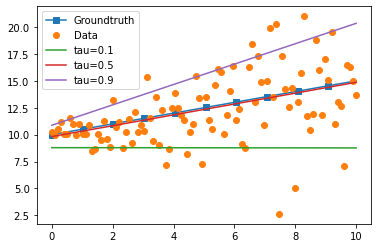

In [ ]:
import numpy as np
from scipy.optimize import minimize

rng = np.random.RandomState(42)
x = np.linspace(start=0, stop=10, num=100)
X = x[:, np.newaxis]  # make X two-dimensional with one column
y_true = 10 + 0.5 * x
y = y_true + rng.normal(loc=0, scale=0.5 + 0.5 * x, size=x.shape[0])

plt.plot(x, y_true, "s-", label='Groundtruth', markevery=10)
plt.plot(x, y, 'o', label="Data")
tau = 0.3

@njit
def pobj(wb, tau):
    w, b = wb[:1], wb[-1]
    return np.mean(pinball(y - X @ w - b, tau=tau))

for tau in [0.1, 0.5, 0.9]:
    w_hat, b_hat = minimize(lambda wb : pobj(wb, tau), x0=[0, 0]).x
    plt.plot(x, x * w_hat + b_hat, label=f"tau={tau}")
    del w_hat, b_hat

plt.legend()
plt.show()

One can observe that the predictions obtained with 0.1 and 0.9 form an interval that can be used to evaluate the uncertainty of the prediction.

## Smoothed pinball loss

Let us define the function:

$$
    \ell_\tau^\delta(z) = \min_{u \in \mathbb{R}} \quad
    \underbrace{
        \ell_\tau(u) + \tfrac{1}{2\delta} (z - u)^2
    }_{J(u)}
$$

#### QUESTION 2:
- Justify that the function $\ell_\tau^\delta: z \rightarrow \ell_\tau^\delta(z)$ is well defined, meaning that a unique function value exists for each value of z.
- Prove that for any $\delta >0$, we have $\ell_\tau^\delta(z) \leq \ell_\tau(z)$.
- Prove that the function $\ell_\tau^\delta$ is given by the formula just below:

$$
    \ell_\tau^\delta (z) = \left\{
	\begin{aligned}
	\tau (z - \frac{\delta \tau}{2}) & \quad \mathrm{ if } \quad  \delta \tau \leq z \\
	\frac{z^2}{2 \delta} & \quad \mathrm{ if } \quad 0 \leq z < \tau \delta \\
	\frac{z^2}{2 \delta} & \quad \mathrm{ if } \quad  -\delta (1 - \tau) \leq z < 0 \\
    (1-\tau) \left( -z - \tfrac{\delta}{2} (1 - \tau) \right) & \quad \mathrm{ otherwise }
	\end{aligned}
    \right.
$$


INSERT YOUR ANSWER HERE

**1.**

* Let us prove that $ J(u) = \ell_\tau(u) + \tfrac{1}{2\delta} (z - u)^2$ is strongly convex. We know that $\ell_\tau(u) = f(u)$ is convex and $\tfrac{1}{2\delta} (z - u)^2 = g(u)$ is strongly convex as a quadratic function.
For ($x$,$y$) $\in \mathbb{R}^{2}$ :

$$
J(\lambda x + (1-\lambda)y) = f(\lambda x + (1-\lambda)y) + g(\lambda x + (1-\lambda)y) \\
\le \lambda (f(x)+g(x)) + (1-\lambda) (f(y)+g(y)) - \lambda (1-\lambda) \frac{\mu}{2} \Vert x - y\Vert^{2}
$$
$J(u)$ is then $\mu$-strongly convex.

* $ \ell_\tau(z) $ is continuous on $\mathbb{R}_{-}^{*}$ and $\mathbb{R}_{+}^{*}$ as affine function. We need to prove that $ \ell_\tau(z) $ is continuous on 0 :
Let $\epsilon > 0$ and $\tau \in [0,1]$.
Let us suppose that  we have $|x| < \delta = \frac{\epsilon}{\tau +1}$.

$$
\begin{align}
& \quad 0 \le |x| < \frac{\epsilon}{\tau +1} \\ 
\Rightarrow & \quad 0 \leq \ell_\tau(|x|) \leq \ell_\tau(\frac{\epsilon}{\tau +1}) \\
\Rightarrow & \quad 0 \leq |\ell_\tau(x)| \leq \ell_\tau(|x|) \leq \frac{\tau\epsilon}{\tau +1} < \epsilon \\
\Rightarrow & \quad |\ell_\tau(x)| < \epsilon \\
\end{align}
$$
Therefore $\ell_\tau$ is continuous and $J(u)$ is continuous as a sum of continuous functions.

$J(u)$ being continuous and $\mu$-strongly convex are both sufficient conditions to guarantee the existence and unicity of the minimizer. We can finally say that $\ell^{\delta}_\tau(z)$ is well defined.
 


**2.**

By definition : 

$$\ell_{\tau}^{\delta}(z) = \min_{u} J(u) , \forall u  \in \mathbb{R}$$
Let $z \in \mathbb{R}$.

$J(z) = \ell_{\tau}(z) + \frac{1}{2δ}(z-z)^2 = \ell_{\tau}(z)$

By definition, $\ell_{\tau}^{\delta}(z)$ is the minimum of all $J(z)$ so $\forall z \in \mathbb{R}$, $\ell_{\tau}^{\delta}(z) ≤ \ell_{\tau}(z)$

**3.**

$$0 \in \partial \ell_{\tau}^{\delta}(u^*) \Leftrightarrow u^* =\mathrm{argmin}_{u} \ell_{\tau}^{\delta}(u) $$

Partial derivative of $\ell_\tau (z)$ w.r.t $z$ :

$$\partial \ell_\tau (z) = \left\{
	\begin{aligned}
	\tau - 1 & \quad \mathrm{ if } \quad  z < 0 \\
	[\tau - 1, \tau] & \quad \mathrm{ if } \quad z = 0 \\
    \tau & \quad \mathrm{ if } \quad z > 0
	\end{aligned}
    \right.
$$ 

Case 1 : $u^* \leq 0$

$$\begin{align}
& \quad (\tau - 1) = \frac{1}{\delta}(z - u^*) \\
\Leftrightarrow & \quad \delta (\tau - 1) = z - u^* \\
\Leftrightarrow & \quad u^* = z - \delta (\tau - 1)\\ 
\end{align}$$

$$\begin{align}
& \quad u^* = z - \delta (\tau - 1) \leq 0\\ 
\Leftrightarrow & \quad z \leq \delta (\tau - 1)
\end{align}$$

$$
\ell_{\tau}^{\delta}(z) = \ell_\tau(u^*) + \frac{1}{2 \delta}(z-u^{*})^2 \\
= \ell_\tau (z - \delta (\tau - 1)) + \frac{1}{2 \delta}(\delta(\tau - 1))^2 \\
= (\tau - 1)(z - \delta (\tau - 1) + \frac{\delta}{2}(\tau - 1)^2 \\
= (\tau - 1)z - \delta (\tau - 1)^2 + \frac{\delta}{2}(\tau - 1)^2 \\
= (\tau - 1)z - \frac{\delta}{2}(\tau - 1)^2 \\
= (1 - \tau)(-z - \frac{\delta}{2}(1 - \tau)) \\
$$

Case 2 : $u^* \geq 0$

$$\begin{align}
& \quad \tau = \frac{1}{\delta}(z - u^*) \\
\Leftrightarrow & \quad \delta \tau = z - u^* \\
\Leftrightarrow & \quad u^* = z - \delta \tau \\ 
\end{align}$$

$$\begin{align}
& \quad u^* = z - \delta \tau \geq 0\\ 
\Leftrightarrow & \quad z \geq \delta \tau
\end{align}$$

$$
\ell_{\tau}^{\delta}(z) = \ell_\tau(u^*) + \frac{1}{2 \delta}(z-u^{*})^2 \\
= \ell_\tau (z - \delta\tau) + \frac{1}{2\delta}(\delta\tau)^2  \\
= \tau(z - \delta\tau) + \frac{\delta}{2}\tau^2 \\
= \tau(z - \delta\tau + \frac{\delta\tau}{2}) \\
= \tau(z - \frac{\delta\tau}{2}) \\
$$

Case 3 : $u^* = 0$

$$\begin{align}
& \quad -(1 - \tau) \le \frac{1}{\delta}(z - u^*) \le \tau \\
\Leftrightarrow & \quad -\delta(1 - \tau) \le z \le \delta\tau 
\end{align}$$

Let us notice that $\ell_\tau(u^*) = 0$ so the function $\ell_{\tau}^{\delta}$ becomes :
$$
\ell_{\tau}^{\delta}(z) = \ell_\tau(u^*) + \frac{1}{2 \delta}(z-u^{*})^2 
= \frac{z^2}{2 \delta}
$$  




#### QUESTION 3:
- Implement the function `smooth_pinball(z, tau, delta)` that applies $\ell_\tau^\delta$ to each entry a numpy array. You will plot the function `smooth_pinball` and `pinball` between -2 and 2.

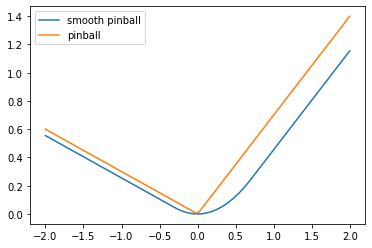

In [ ]:
@vectorize
def smooth_pinball_vectorized(z, tau, delta):
    if z >= tau * delta:
      return tau * (z - delta * tau / 2)
    elif tau * delta > z >= - delta * (1 - tau):
      return z ** 2 / (2 * delta)
    else:
      return (1 - tau) * (-z - delta/2 * (1 - tau))

@njit
def smooth_pinball(z, tau, delta):
    """Compute the smoothed pinball loss
    
    Parameters
    ----------
    z : array-like, shape (n_samples,)
        The array on which to compute the smoothed pinball loss.
    tau : float in [0, 1]
        The quantile.
    delta : float
        The smoothing parameter.
    
    Returns
    -------
    l : array-like, shape (n_samples,)
        The smoothed pinball loss values.
    """
    out = z.copy().astype(np.float64)
    ### TODO
    out = smooth_pinball_vectorized(z, tau, delta)
    ### END TODO
    return out

### TODO plotting
tau = 0.7
delta = 1
z = np.linspace(-2, 2, 100)
plt.figure()
plt.plot(z, smooth_pinball(z, tau, delta), label="smooth pinball")
plt.plot(z, pinball(z, tau), label="pinball")
plt.legend()
plt.show()
### END TODO

#### QUESTION 4:
- What is the derivative of the smoothed pinball loss $\ell_\tau^\delta$?
- Justify that the derivative of the smoothed pinball loss is continuous.
- Justify that the function $\ell_\tau^\delta$ is L-smooth. Propose a value for the Lipschitz constant of its gradient.
- Justify that the function $\ell_\tau^\delta$ is convex. Is it strongly convex?
- Implement the function `grad_smooth_pinball(z, tau, delta)` that applies the derivative of $\ell_\tau^\delta$ to each entry of a numpy array.

**Remark:** You will use the `scipy.optimize.check_grad` function to assess the validity of your result. You will need to test your gradient in both the linear and quadratic regions of the function (not just in one location).

ANSWERS

**1.**
Let us calculate the derivative of the smoothed pinball loss $\ell_\tau^\delta$?

$$
    \nabla \ell_\tau^\delta (z) = \left\{
	\begin{aligned}
	\tau & \quad \mathrm{ if } \quad  \delta \tau \leq z \\
	\frac{z}{\delta} & \quad \mathrm{ if } \quad  -\delta (1 - \tau) \leq z < \delta\tau \\
    (\tau - 1) & \quad \mathrm{ otherwise }
	\end{aligned}
    \right.
$$


**2.**

$\nabla\ell_\tau^\delta(z)$ is continuous on $]\delta\tau,+\infty[$,
$]\delta\tau,-\delta(1-\tau)[$ and $]-\infty,-\delta(1-\tau)[$ as affine function. We need to prove that $ \nabla\ell_\tau^\delta(z) $ is continuous on $\delta\tau$ and $-\delta(1-\tau)$ :

* For $\delta\tau$ :
	$\lim\limits_{z \rightarrow +\delta\tau^+} \nabla\ell_\tau^\delta(z)= \lim\limits_{z \rightarrow +\delta\tau^-} \nabla\ell_\tau^\delta(z) = \nabla\ell_\tau^\delta(\delta\tau) =\tau$

* For $\delta(\tau-1)$ :
	$\lim\limits_{z \rightarrow +\delta(\tau-1)^+} \nabla\ell_\tau^\delta(z)= \lim\limits_{z \rightarrow +\delta(\tau-1)^-} \nabla\ell_\tau^\delta(z) = \nabla\ell_\tau^\delta(\delta(\tau-1)) =\tau-1$


We can conclude that $\nabla\ell_\tau^\delta$ is continuous.


**3.**
Let us calculate the Hessian : 

$$
    \nabla^2 \ell_\tau^\delta (z) = \left\{
	\begin{aligned}
	\frac{1}{\delta} & \quad \mathrm{ if } \quad  -\delta (1 - \tau) \leq z < \delta\tau \\
    0 & \quad \mathrm{ otherwise }
	\end{aligned}
    \right.
$$

which is always majorized by $\frac{1}{\delta}$. We can therefore pick $\frac{1}{\delta}$ as the Lipschitz constant of its gradient such that $\ell_\tau^\delta$ is $\frac{1}{\delta}$-smooth.


**4.** 

For $\delta ≥ 0$ , $\nabla^2 \ell_\tau^\delta$ is positive so $ \ell_\tau^\delta$ is convex. It is actually not strongly convex because the Hessian can be equal to 0 which nullifies the strongly convex property. 


check_grad maximum error: 1.1920928910669204e-08


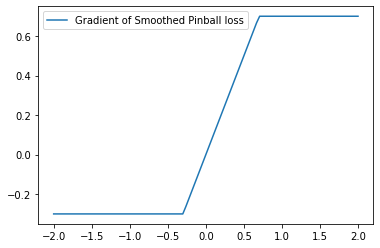

In [ ]:
@vectorize
def grad_smooth_pinball_vectorized(z, tau, delta):
    if z >= tau * delta:
      return tau
    elif tau * delta > z >= - delta * (1 - tau):
      return z / delta
    else:
      return tau - 1

@njit
def grad_smooth_pinball(z, tau=tau, delta=delta):
    """Compute the derivative of the smoothed pinball loss
    
    Parameters
    ----------
    z : array-like, shape (n_samples,)
        The array on which to compute the smoothed pinball loss.
    tau : float in [0, 1]
        The quantile.
    delta : float
        The smoothing parameter.
    
    Returns
    -------
    dl : array-like, shape (n_samples,)
        The derivative of smoothed pinball loss computed element-wise.
    """
    out = z.copy().astype(np.float64)
    ### TODO
    out = grad_smooth_pinball_vectorized(z, tau, delta)
    ### END TODO
    return out

x = np.linspace(-2, 2, 100)
tau = 0.7
delta = 1
plt.plot(x, grad_smooth_pinball(x, tau=tau, delta=delta), label='Gradient of Smoothed Pinball loss')
plt.legend();

from scipy.optimize import check_grad

### TODO check gradient with check_grad function.
errors = []
for x_i in x:
  errors.append(check_grad(smooth_pinball_vectorized, grad_smooth_pinball_vectorized, x_i, tau, delta))
print("check_grad maximum error:", np.max(errors))
### END TODO

From now on, we consider the following optimization problem:

$$
    (\mathcal{P}_\delta^\mathcal{R}): \min_{w, b} \quad L_\delta(w, b) + \lambda \mathcal{R}(w)
$$

where $\mathcal{R}(w)$ can be $\mathcal{R}_1(w)$ or $\mathcal{R}_2(w)$, and where $L_\delta(w, b) = \frac{1}{N} \sum_{i=1}^N \ell_\tau^\delta(y_i - w^\top x_i - b)$.

#### QUESTION 5:
- Justify what optimization strategy among L-BFGS, (proximal-)gradient descent, (proximal-)coordinate descent is readily applicable
  for $(\mathcal{P}_\delta^{\mathcal{R}_2})$ and $(\mathcal{P}_\delta^{\mathcal{R}_1})$.

INSERT YOUR ANSWER HERE

$(\mathcal{P}_\delta^{\mathcal{R}_2})$ and $(\mathcal{P}_\delta^{\mathcal{R}_1})$ are two convex optimization problems. Therefore, we can already apply L-BFGS, Proximal Gradient Descent, Proximal Coordinate Descent. Methods of gradient descent and coordinate descent are not well suited for problems with regularization.

#### QUESTION 6:
- Solve the optimization prolem $(\mathcal{P}_\delta^{\mathcal{R}_2})$ using the `fmin_l_bfgs_b` function from `scipy.optimize`. You are expected to provide the explicit gradient (fprime parameter) to `fmin_l_bfgs_b`.
- Using the simulated dataset from above, you will check that your solver gives comparable results as obtained above without smoothing when setting a very small value for $\lambda$. Your are expected to make a plot of the regression fit.

The estimate of $w$ and $b$ should be called `w_hat` and `b_hat`. You will call the regularization parameter $\lambda$ as `lbda` in the code.

To help you, we provide you with the function `pobj_l2` that computes the objective to minimize. Note that the parameters `w` and `b` are combined in a single array `params`.

with low regularization (lbda=0.01): [0.58848751] 9.96609553533547
without regularization: 0.6278983023575916 9.91085780956955


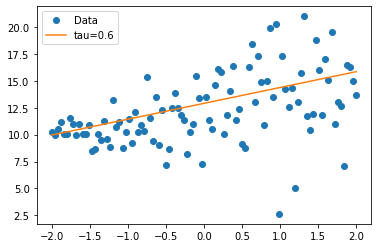

In [ ]:
from scipy.optimize import fmin_l_bfgs_b

lbda = 0.01
delta = 0.5
tau = 0.6

def pobj_l2(params, X=X, y=y, lbda=lbda, tau=tau, delta=delta):
    """Objective function with L2 penalty."""
    b, w = params[0], params[1:]
    residual = y - np.dot(X, w) - b

    return np.mean(smooth_pinball(residual, tau=tau, delta=delta)) + lbda * np.sum(w ** 2)

def pobj_l2_grad(params, X=X, y=y, lbda=lbda, tau=tau, delta=delta):
    b, w = params[0], params[1:]
    residual = y - np.dot(X, w) - b

    f_grad_w = 1/X.shape[0] * np.dot(-X.T, grad_smooth_pinball(residual, tau=tau, delta=delta)) + 2 * lbda * np.sum(w)

    f_grad_b = -np.mean(grad_smooth_pinball(residual, tau=tau, delta=delta))
    f_grad_b = f_grad_b[np.newaxis]

    return np.concatenate((f_grad_b, f_grad_w))

def smooth_pinball_lbfgs_l2(X=X, y=y, lbda=lbda, tau=tau, delta=delta):
    """Estimate w and b using L-BFGS.
    
    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
        The array of features.
    y : ndarray, shape (n_samples,)
        The target.
    lbda : float
        The regularization parameter lbda
    tau : float in [0, 1]
        The quantile.
    delta : float
        The smoothing parameter.
    
    Returns
    -------
    w_hat : ndarray, shape (n_features,)
        The estimated w.
    b_hat : float
        The estimated b.
    """
    # TODO
    bw0 = np.zeros(1 + X.shape[1])
    bw_hat, _, _ = fmin_l_bfgs_b(pobj_l2, x0=bw0, fprime=pobj_l2_grad, args=(X, y, lbda, tau, delta))
    b_hat, w_hat = bw_hat[0], bw_hat[1:]
    # END TODO
    return w_hat, b_hat

w_hat, b_hat = smooth_pinball_lbfgs_l2(X, y, lbda=lbda, tau=tau, delta=delta)
y_pred = np.dot(X, w_hat) + b_hat

# TODO  (visualization of the fit)
# with low regularization (lbda=0.01)
print(f"with low regularization (lbda={lbda}):", w_hat, b_hat)
# without regularization
w_min, b_min = minimize(lambda wb : pobj(wb, tau), x0=[0, 0]).x
print("without regularization:", w_min, b_min)

plt.figure()
plt.plot(x, y, 'o', label="Data")
plt.plot(x, y_pred, label=f"tau={tau}")
plt.legend()
plt.show()
# END TODO

**Answer**

We saw that L-BFGS solver with low regularization ($\lambda = 0.01$) gives comparable results as obtained with `scipy.optimize.minimize`.

## Part 2: Smooth quantile regression with L1 regularization

In this section we are interested in the $\ell_1$ regularized model.
To help you we give you the code of the objective function to minimize.

In [ ]:
def pobj_l1(params, X=X, y=y, lbda=lbda, tau=tau, delta=delta):
    w = params[1:]
    b = params[0]
    residual = y - np.dot(X, w) - b
    return np.mean(smooth_pinball(residual, tau=tau, delta=delta)) + lbda * np.sum(np.abs(w))

Now that we have the cost function, you are going to implement solvers based on:

- Proximal Gradient Descent (PGD aka ISTA)
- Accelerated Proximal Gradient Descent (APGD aka FISTA)
- Proximal Coordinate Descent (PCD)

Before this we are going to define the `monitor` class previously used in the second lab as well as plotting functions useful to monitor convergence.

In [ ]:
class monitor(object):
    def __init__(self, algo, obj, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.obj = obj
        self.args = args
        if self.x_min is not None:
            self.f_min = obj(x_min, *args)

    def run(self, *algo_args, **algo_kwargs):
        t0 = time.time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time.time() - t0
        self.x_list = x_list
        if self.x_min is not None:
            self.err = [linalg.norm(x - self.x_min) for x in x_list]
            self.obj = [self.obj(x, *self.args) - self.f_min for x in x_list]
        else:
            self.obj = [self.obj(x, *self.args) for x in x_list]


def plot_epochs(monitors, solvers):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    for monit in monitors:
        ax1.semilogy(monit.obj, lw=2)
        ax1.set_title("Objective")
        ax1.set_xlabel("Epoch")
        if monit.x_min is None:
            ax1.set_ylabel("$f(x_k)$")
        else:
            ax1.set_ylabel("$f(x_k) - f(x^*)$")

    ax1.legend(solvers)

    for monit in monitors:
        if monit.x_min is not None:
            ax2.semilogy(monit.err, lw=2)
            ax2.set_title("Distance to optimum")
            ax2.set_xlabel("Epoch")
            ax2.set_ylabel("$\|x_k - x^*\|_2$")

    ax2.legend(solvers)


def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

#### QUESTION 7a:
- Implement the proximal gradient descent (PGD) method.

**Note:**  The parameter `step` is the size of the gradient step that you will need to propose by computing the Lipschitz constant of the data fitting term (Smooth pinball term without regularization term).

**ANSWER**

$$
    (\mathcal{P}_\delta^\mathcal{R}): \min_{w, b} \quad L_\delta(w, b) + \lambda \mathcal{R}(w)
$$

where $\mathcal{R}(w)$ can be $\mathcal{R}_1(w)$ or $\mathcal{R}_2(w)$, and where $L_\delta(w, b) = \frac{1}{N} \sum_{i=1}^N \ell_\tau^\delta(y_i - w^\top x_i - b)$.

$$\nabla_{b}L_\delta(w, b) = -\frac{1}{N}\sum_{i=1}^N  1_{N}*\nabla_{b} \ell_\tau^\delta(y_i - w^\top x_i - b), \nabla_{w}L_\delta(w, b) = -\frac{1}{N}\sum_{i=1}^N x_{i}^T \nabla_{w} \ell_\tau^\delta(y_i - w^\top x_i - b)$$

$$\nabla_{b}L_\delta(w, b) = \frac{1}{N}\sum_{i=1}^N  1_{N}*\nabla_{b}^2 \ell_\tau^\delta(y_i - w^\top x_i - b), \nabla_{w}^2L_\delta(w, b) = \frac{1}{N}\sum_{i=1}^N x_{i}^Tx_{i} \nabla_{w}^2 \ell_\tau^\delta(y_i - w^\top x_i - b)$$

We should therefore take as smoothness constant :     
$$\frac{1}{\delta N}\Vert X^TX \Vert_{2} = \frac{1}{\delta N}\Vert X \Vert^2_{2}$$

In [ ]:
def pgd(x_init, grad, prox, step, n_iter=100, store_every=1,
        grad_args=(), prox_args=()):
    """Proximal gradient descent algorithm.
    
    Parameters
    ----------
    x_init : array, shape (n_parameters,)
        Parameters of the optimization problem.
    grad : callable
        The gradient of the smooth data fitting term.
    prox : callable
        The proximal operator of the regularization term.
    step : float
        The size of the gradient step done on the smooth term.
    n_iter : int
        The number of iterations.
    store_every : int
        At which frequency should the current iterated be remembered.
    grad_args : tuple
        Parameters to pass to grad.
    prox_args : tuple
        Parameters to pass to prox.
    
    Returns
    -------
    x : array, shape (n_parameters,)
        The estimated parameters.
    x_list : list
        The list if x values along the iterations.
    """
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        update = x - (1/step) * grad(x, *grad_args)
        x[0] = update[0] # ignore intercept
        x[1:] = prox(update[1:], step, *prox_args)
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

#### QUESTION 7b:</b>
- Implement the L1 and L2 proximal operators. You will pay attention to the intercept.
- Using the monitor class and the plot_epochs function, display the convergence.

In order to get a good value of `x_min` you will let your PGD solver run for 10000 iterations.

First you will need to implement the proximal operator functions for $\ell_1$ and $\ell_2$ regularized models.

In [ ]:
@njit
def prox_R2(params, reg=1.):
    # TODO
    params = params / (1 + 2 * reg)
    # END TODO
    return params

@njit
def prox_R1(params, reg=1.):
    # TODO
    params = np.sign(params) * np.maximum(0, np.abs(params) - reg)
    # END TODO
    return params

@njit
def prox_l2(params, step, lbda):
    return prox_R2(params, reg= lbda * step)

@njit
def prox_l1(params, step, lbda):
    return prox_R1(params, reg= lbda * step)

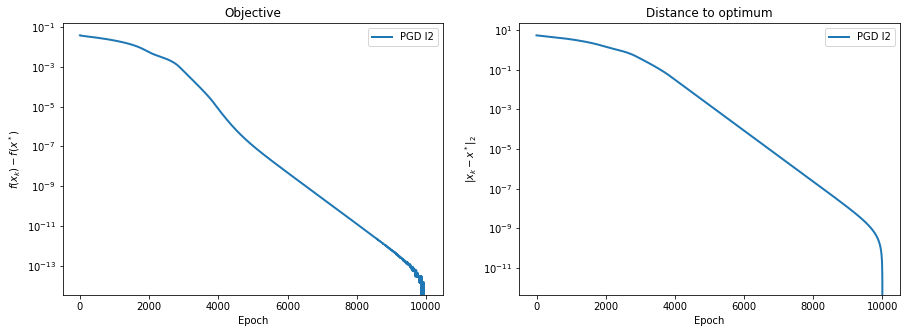

In [ ]:
# Generate bigger data
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=500, n_features=100, random_state=0,
                       noise=4.0, bias=10.0)
n_samples, n_features = X.shape

# Set initial values of parameters to optimize
x_init = np.zeros(n_features + 1)
x_init[0] = np.mean(y)
n_iter = 10_000
lbda = 1
delta = 0.5
tau = 0.5

# TODO (implement function grad_smooth_pinball_loss and define step)
@njit
def grad_smooth_pinball_loss(params, X, y, tau, delta):
  b, w = params[0], params[1:]
  residual = y - np.dot(X, w) - b

  grad = np.empty_like(params)
  # update w
  grad[1:] = 1/X.shape[0] * np.dot(-X.T, grad_smooth_pinball(residual, tau=tau, delta=delta))
  # update b
  grad[0] = np.mean(-grad_smooth_pinball(residual, tau=tau, delta=delta))

  return grad

step = 1 / (delta * n_samples) * np.linalg.norm(X, ord = 2)**2
# END TODO

# Get a good x_min by letting the algorithm converge with many iterations
x_min, _ = pgd(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter=n_iter, store_every=1000,
               grad_args=(X, y, tau, delta), prox_args=(lbda,))
# Run PGD
monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min, args=(X, y, lbda, tau, delta))
monitor_pgd_l2.run(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))

monitors = [monitor_pgd_l2]
solvers = ["PGD l2"]
plot_epochs(monitors, solvers)

Now for the $\ell_1$ regularization:

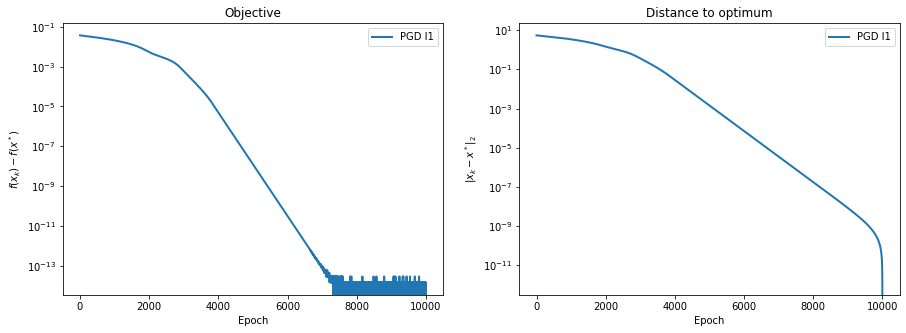

In [ ]:
# Run PGD for L1

x_min_l1, _ = pgd(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter=10000, store_every=1000,
               grad_args=(X, y, tau, delta), prox_args=(lbda,))
monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, tau, delta))
monitor_pgd_l1.run(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))

monitors = [monitor_pgd_l1]
solvers = ["PGD l1"]
plot_epochs(monitors, solvers)

QUESTION 8:
- Implement the accelerated proximal gradient descent (APGD) and add this solver to the monitoring plots.

In [ ]:
def apgd(x_init, grad, prox, step, n_iter=100, store_every=1,
         grad_args=(), prox_args=()):
    """Accelerated proximal gradient descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        ### TODO
        update = y - 1/step * grad(y, *grad_args)
        x_new = prox(update, step, *prox_args)
        x_new[0] = update[0] # intercept
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        y = x_new + (t - 1) / t_new * (x_new - x)
        x = x_new
        t = t_new
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

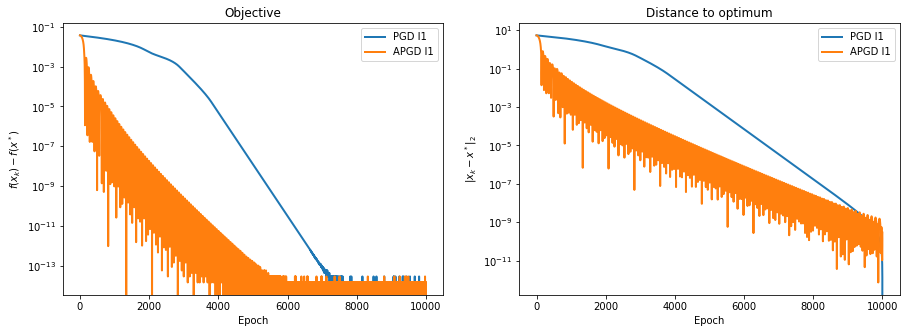

In [ ]:
# TODO
monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, tau, delta))
monitor_apgd_l1.run(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))
# END TODO

monitors = [monitor_pgd_l1, monitor_apgd_l1]
solvers = ["PGD l1", "APGD l1"]
plot_epochs(monitors, solvers)

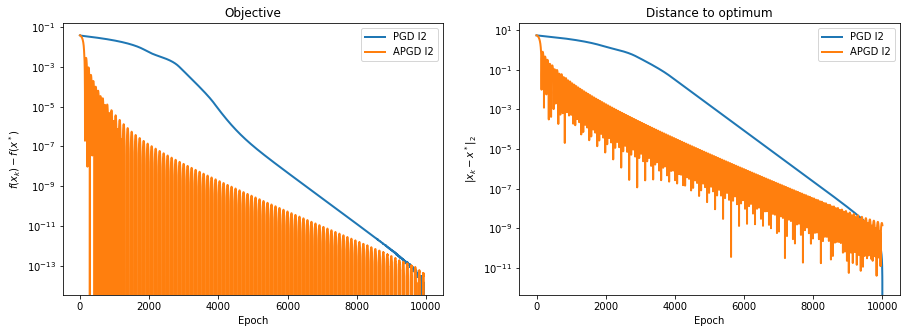

In [ ]:
# TODO
x_min_l2 = x_min
monitor_apgd_l2 = monitor(apgd, pobj_l2, x_min=x_min_l2, args=(X, y, lbda, tau, delta))
monitor_apgd_l2.run(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))
# END TODO

monitors = [monitor_pgd_l2, monitor_apgd_l2]
solvers = ["PGD l2", "APGD l2"]
plot_epochs(monitors, solvers)

#### QUESTION 9
- Implement the proximal coordinate descent (PCD) and add this solver to the monitoring plots for L1 and L2 regularized models.

**Note:** You are welcome to try to use numba to get reasonable performance but don't spend too much time if you get weird numba errors.

In [ ]:
@njit
def grad_j_smooth_pinball_loss(params, j, X=X, y=y, tau=tau, delta=delta):
  b, w = params[0], params[1:]
  residual = y - np.dot(X, w) - b
  if j == 0:
    return -np.mean(grad_smooth_pinball(residual, tau=tau, delta=delta))
  return 1/X.shape[0] * np.dot(-X[:, j-1], grad_smooth_pinball(residual, tau=tau, delta=delta))

In [ ]:
# TODO
@njit
def pcd(x_init, grad, prox, step, n_iter=100, store_every=1,
         grad_args=(), prox_args=()):
    x = x_init.copy()
    x_list = []
    n_features = x_init.shape[0] 

    for t in range(n_iter):
      # 1st feature : intercept/bias
      x[0] = x[0] - 1/step[0] * grad(x, 0, *grad_args)

      # other features : proximal coordinate descent
      for j in range(1, n_features):
          x[j] = prox(x[j] - 1 / step[j] * grad(x, j, *grad_args), step[j], *prox_args)

      if t % store_every == 0:
        x_list.append(x.copy())

    return x, x_list
# END TODO

lipschitz_c = np.zeros(X.shape[1] + 1)
lipschitz_c[1:] = 1 / (delta * n_samples) * np.sum(X**2, axis = 0)
lipschitz_c[0] = 1 / delta
step_pcd =  lipschitz_c

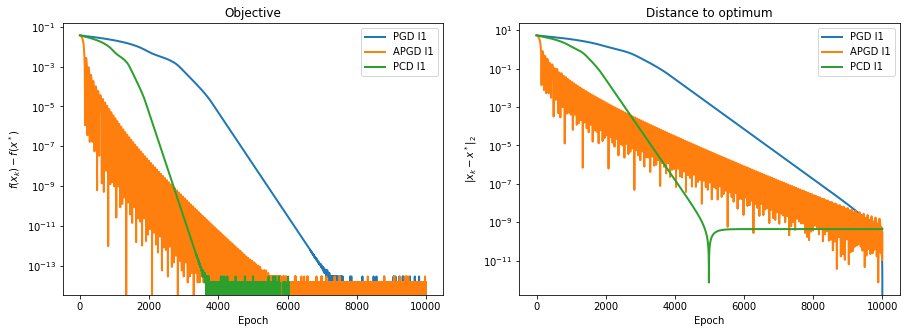

In [ ]:
monitor_pcd_l1 = monitor(pcd, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, tau, delta))
monitor_pcd_l1.run(x_init, grad_j_smooth_pinball_loss, prox_l1, step_pcd, n_iter,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))

monitors = [monitor_pgd_l1, monitor_apgd_l1, monitor_pcd_l1]
solvers = ["PGD l1", "APGD l1", "PCD l1"]


plot_epochs(monitors, solvers)

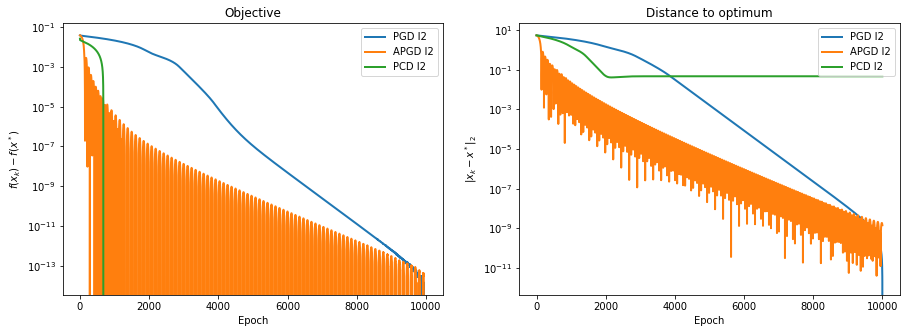

In [ ]:
monitor_pcd_l2 = monitor(pcd, pobj_l2, x_min=x_min_l2, args=(X, y, lbda, tau, delta))
monitor_pcd_l2.run(x_init, grad_j_smooth_pinball_loss, prox_l2, step_pcd, n_iter,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))

monitors = [monitor_pgd_l2, monitor_apgd_l2, monitor_pcd_l2]
solvers = ["PGD l2", "APGD l2", "PCD l2"]

plot_epochs(monitors, solvers)

**Answer**

- PGD : We have a linear convergence both for the l1 and l2 norms.
- APGD : We observe that APGD converges faster to the same minimum as PGD. Oscillations are due to the extrapolation method.
- PCD : For l1 norm, PCD approaches the same minimizer as PGD, but starts to get away. Nonetheless, the value of the objective stays very close to the minimum. For L2 norm, minimizer found by PCD is not very close from the minimizer found with PGD, but the objective values converge to 1e-13 and the convergence is really fast.

#### QUESTION 10
- Compare the performance of the different solvers for different (simulated) problem sizes. You will test on a dataset with n_samples >> n_features, n_samples << n_features, and for high and low values of $\lambda$.
- What solver would you recommend for each of the 4 scenarios?

**Remark:** What is expected from you here is to provide clear and synthetic plots that show the performance of the different solvers for the different simulated datasets.

YOUR ANSWER HERE

Lambda: 1 ; n_samples: 1000 ; n_features: 100
scipy.optimize.minimize 63.585536356663695
pgd 63.58504840996598
apgd 63.58504840996598
pcd 63.58504840996598


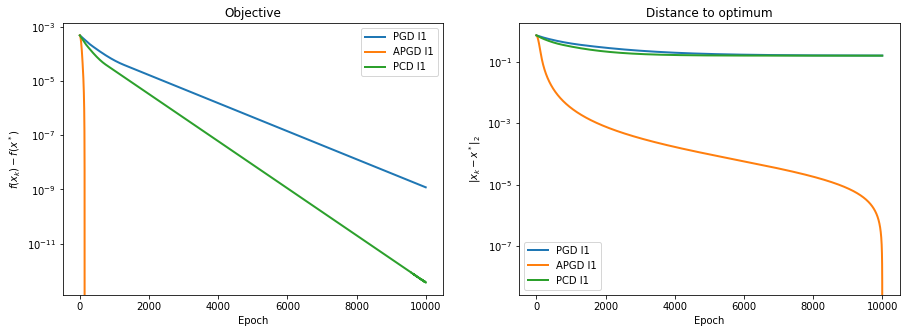

Lambda: 1 ; n_samples: 100 ; n_features: 1000
scipy.optimize.minimize 71.36160242806173
pgd 71.29646215421756
apgd 71.29646215421756
pcd 71.29646215421756


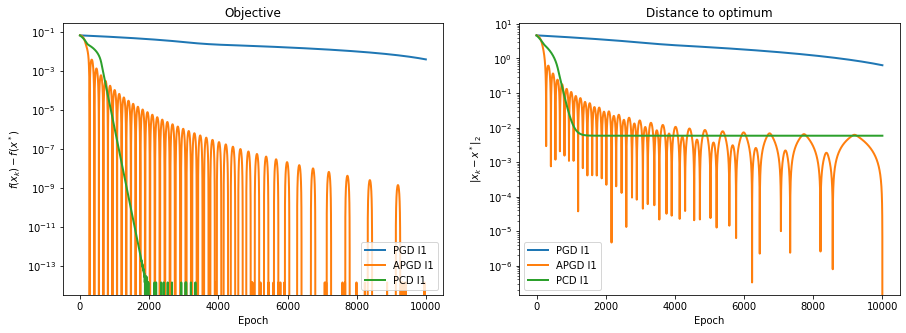

Lambda: 100 ; n_samples: 1000 ; n_features: 100
scipy.optimize.minimize 63.585536356663695
pgd 63.58504840996598
apgd 63.58504840996598
pcd 63.58504840996598


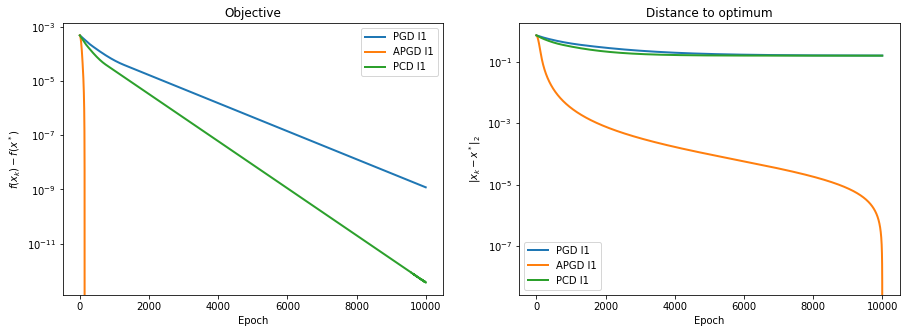

Lambda: 100 ; n_samples: 100 ; n_features: 1000
scipy.optimize.minimize 71.36160242806173
pgd 71.29646215421756
apgd 71.29646215421756
pcd 71.29646215421756


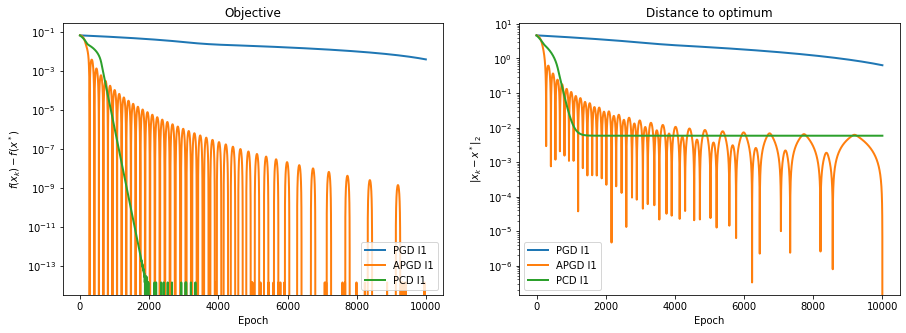

In [ ]:
lbdas = [1, 100]
delta = 0.5
tau = 0.5

def run_monitors(X, y, tau, delta, lbda):
  n_samples, n_features = X.shape

  x_init = np.zeros(n_features + 1)
  x_init[0] = np.mean(y)
  
  step = 1 / (delta * n_samples) * np.linalg.norm(X, ord = 2)**2

  print("Lambda:", lbda, "; n_samples:", n_samples, "; n_features:", n_features)

  x_min_l1, _ = apgd(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter=10000, store_every=1000,
                grad_args=(X, y, tau, delta), prox_args=(lbda,))
  
  print("scipy.optimize.minimize", minimize(lambda wb : pobj_l1(wb, X=X, y=y, lbda=lbda, tau=tau, delta=delta), x0=x_init).fun)
  
  monitors = []
  
  for algo in [pgd, apgd, pcd]:
    if algo == pcd:
      grad = grad_j_smooth_pinball_loss
      lipschitz_c = np.zeros(n_features + 1)
      lipschitz_c[0] = 1 / delta
      lipschitz_c[1:] = 1 / (delta * n_samples) * np.sum(X**2, axis = 0)
      step = lipschitz_c.copy()
    else:
      grad = grad_smooth_pinball_loss
      step = 1 / (delta * n_samples) * np.linalg.norm(X, ord = 2)**2

    monitor_l1 = monitor(algo, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, tau, delta))
    monitor_l1.run(x_init, grad, prox_l1, step, n_iter, store_every=1,
                      grad_args=(X, y, tau, delta), prox_args=(lbda,))
    
    print(algo.__name__, pobj_l1(monitor_l1.x_min, X=X, y=y, lbda=lbda, tau=tau, delta=delta))
    
    monitors.append(monitor_l1)

  solvers = ["PGD l1", "APGD l1", "PCD l1"]

  plot_epochs(monitors, solvers)
  plt.show()

for lbda in lbdas:
  X, y = make_regression(n_samples=1000, n_features=100, random_state=0,
                        noise=4.0, bias=10.0)

  run_monitors(X, y, tau, delta, lbda)

  X, y = make_regression(n_samples=100, n_features=1000, random_state=0,
                        noise=4.0, bias=10.0)

  run_monitors(X, y, tau, delta, lbda)

ANSWER

* When n_samples >> n_features : APGD solver is doing much better than PGD which is coherent (FISTA : $f(w^T) - f(w^*) = O(\frac{1}{T^2})$ vs ISTA : $f(w^T) - f(w^*) = O(\frac{1}{T})$). When the number of features is low, coordinate gradient descent does not perform better than APGD.

* When n_samples << n_features : Proximal coordinate descent is the preferred method since for every iteration, it will updates *n_features* times the weights so it captures much more information than PGD and APGD. The convergences of this 2 methods is slow.

* When $\lambda$ is high : $\lambda$ has almost no influence on the performances of the solver. When the number of features is very high compared to the number of samples, APGD is the best opposed to PCD 

* When $\lambda$ is low : $\lambda$ has almost no influence on the performances of the solver. When the number of features is very high compared to the number of samples, APGD is the best opposed to PCD 

# Part 3: Application

You will now apply your solver to some census dataset where we aim to predict the wage of a person give some demographic and work related variables.

**Disclaimer:** This dataset is not huge and regularization makes little sense with so little features but it serves as a simple illustration.

Let's first inspect the dataset:

In [ ]:
from sklearn.datasets import fetch_openml
wages = fetch_openml(name="cps_85_wages", as_frame=True)
X_df, y_df = wages["data"], wages["target"]
X_df.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8.0,no,female,21.0,not_member,35.0,Hispanic,Other,Manufacturing,Married
1,9.0,no,female,42.0,not_member,57.0,White,Other,Manufacturing,Married
2,12.0,no,male,1.0,not_member,19.0,White,Other,Manufacturing,Unmarried
3,12.0,no,male,4.0,not_member,22.0,White,Other,Other,Unmarried
4,12.0,no,male,17.0,not_member,35.0,White,Other,Other,Married


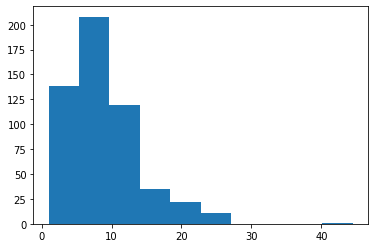

In [ ]:
plt.hist(y_df);

In [ ]:
X_df.dtypes

EDUCATION      float64
SOUTH         category
SEX           category
EXPERIENCE     float64
UNION         category
AGE            float64
RACE          category
OCCUPATION    category
SECTOR        category
MARR          category
dtype: object

Now let's extract `X` taking only the numerical columns (y is already defined above) and do some basic plot:

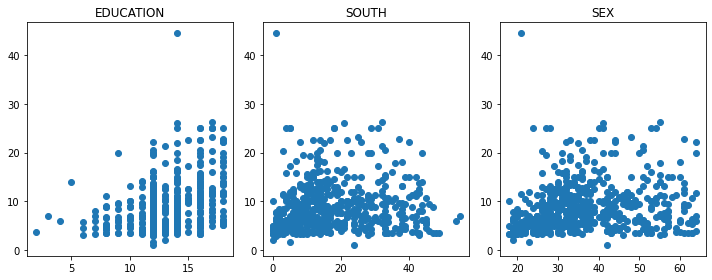

In [ ]:
X_df_num = X_df.select_dtypes(include=(float, int))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
for x, col_name, ax in zip(X_df_num.values.T, X_df.columns, axes.ravel()):
    ax.plot(x, y_df, 'o')
    ax.set_title(col_name)
fig.tight_layout()

In [ ]:
X = X_df_num.values
y = y_df.values
y.shape, X.shape

((534,), (534, 3))

We have now X and y!

In order to facilitate our experiment we're going to write a full scikit-learn estimator.

#### QUESTION 11
- Implement the `fit` method from the estimator in the next cell and fit the model with the different solvers you implemented above.

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import scale


class SmoothQuantileRegressor(BaseEstimator, RegressorMixin):
    """scikit-learn estimator for regression with a smoothed quantile loss.
    
    Parameters
    ----------
    lbda : float
        The regularization parameter
    penalty : 'l1' | 'l2'
        The type of regularization to use.
    tau : float in (0, 1)
        The quantile to predict.
    delta : float
        The smoothing parameter.
    max_iter : int
        The number of iterations / epochs to do on the data.
    solver : 'pgd' | 'apgd' | 'pcd'
        The type of algorithm to use.
        
    Attributes
    ----------
    coef_ : ndarray, (n_features,)
        The weitghs w.
    intercept_ : float
        The intercept or bias term b.
    """
    def __init__(self, lbda=1., penalty='l2', tau=0.5, delta=0.5,
                 max_iter=2000, solver='pgd'):
        self.lbda = lbda
        self.penalty = penalty
        self.tau = tau
        self.delta = delta
        self.max_iter = max_iter
        self.solver = solver
        assert self.penalty in ['l1', 'l2']
        assert self.solver in ['pgd', 'apgd', 'pcd'], "only supported methods: ['pgd', 'apgd', 'pcd']" 

    def fit(self, X, y):
        """Fit method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
        """
        n_samples, n_features = X.shape
        # TODO
        x_init = np.zeros(1 + X.shape[1])

        prox = None
        if self.penalty == "l1":
          prox = prox_l1
        elif self.penalty == "l2":
          prox = prox_l2

        method = None
        grad = grad_smooth_pinball_loss
        step = (1 / delta) * (np.linalg.norm(X, ord = 2)**2 / n_samples)
        if self.solver == "pgd":
          method = pgd
        elif self.solver == "apgd":
          method = apgd
        elif self.solver == "pcd":
          method = pcd
          grad = grad_j_smooth_pinball_loss
          lipschitz_c = np.zeros(X.shape[1] + 1)
          lipschitz_c[1:] = 1 / (delta * n_samples) * np.sum(X**2, axis = 0)
          lipschitz_c[0] = 1 / delta
          step = lipschitz_c

        x, _ = method(x_init, grad, prox, step, n_iter=self.max_iter, store_every=1000,
              grad_args=(X, y, self.tau, self.delta), prox_args=(self.lbda,))
        # END TODO
        self.params_ = x
        self.coef_ = x[1:]
        self.intercept_ = x[0]
        return self

    def predict(self, X):
        """Predict method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_pred : ndarray, shape (n_samples,)
            The predicted target.
        """
        return np.dot(X, self.coef_) + self.intercept_

    
    def score(self, X, y):
        """Score using the pinball loss.
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
            
        Returns
        -------
        score : float
            The negative pinball loss.
            Negative to keep the semantic that higher is better.
        """
        return -np.mean(pinball(y - self.predict(X), tau=self.tau))

lbda = 1e-4
max_iter = 1000

X_scaled = scale(X)  # standardize the features

for solver in ['pgd', 'apgd', 'pcd']:
    clf = SmoothQuantileRegressor(lbda=lbda, penalty='l2', max_iter=max_iter, solver=solver)
    clf.fit(X_scaled, y)
    print('Solver with L2: %s   \t-   Pinball : %.5f' % (solver, -clf.score(X, y)))

for solver in ['pgd', 'apgd', 'pcd']:
    clf = SmoothQuantileRegressor(lbda=lbda, penalty='l1', max_iter=max_iter, solver=solver)
    clf.fit(X_scaled, y)
    print('Solver with L1: %s   \t-   Pinball : %.5f' % (solver, -clf.score(X, y)))

Solver with L2: pgd   	-   Pinball : 33.58169
Solver with L2: apgd   	-   Pinball : 33.43568
Solver with L2: pcd   	-   Pinball : 34.07366
Solver with L1: pgd   	-   Pinball : 34.57330
Solver with L1: apgd   	-   Pinball : 38.00946
Solver with L1: pcd   	-   Pinball : 34.27475


To illustrate the predicitons here is a simple plot where you should see the interval of the predictions with 3 different quantiles. Feel free to comment on what you see and go beyond this plot if you feel inspired !

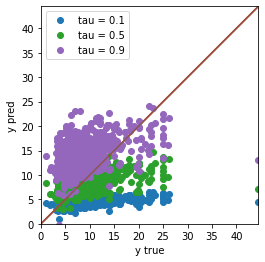

In [ ]:
fig, ax = plt.subplots()
for tau in [0.1, 0.5, 0.9]:
    clf = SmoothQuantileRegressor(lbda=lbda, penalty='l2', solver="apgd", tau=tau)
    y_pred = clf.fit(X_scaled, y).predict(X_scaled)
    ax.plot(y, y_pred, 'o', label=f'tau = {tau:.1f}')
    ax.plot([0, 51], [0, 51])
    ax.set_xticks(np.arange(0, 51, 5))
    ax.set_yticks(np.arange(0, 51, 5))
    ax.axis("square")

ax.set(xlabel="y true", ylabel="y pred", xlim=(0, np.max(y)), ylim=(0, np.max(y)))
plt.legend();

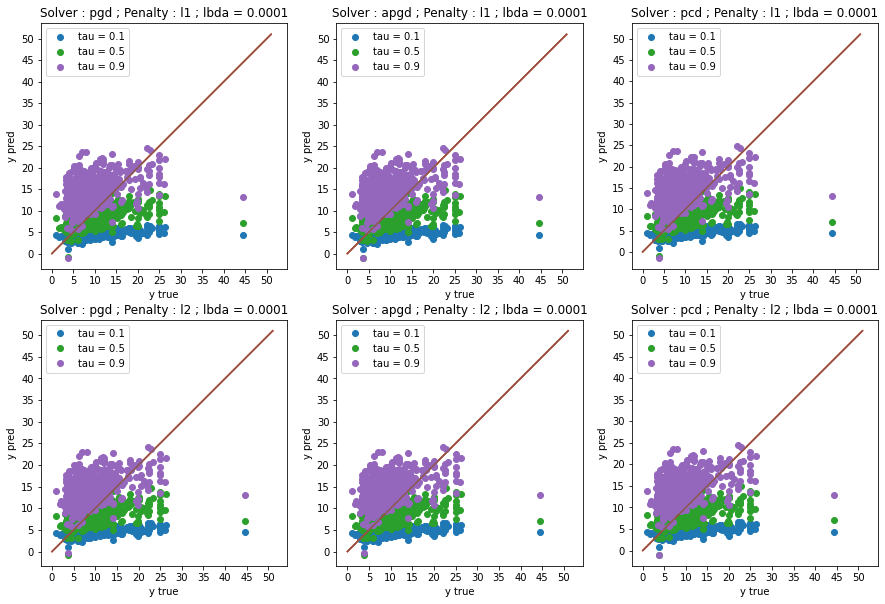

In [ ]:
lbda = 1e-4
solvers = ["pgd","apgd","pcd"]
penalties = ["l1","l2"]
fig, ax = plt.subplots(len(penalties), len(solvers), figsize = (15,10))
for row in range(len(penalties)):
  for col in range(len(solvers)):
    for tau in [0.1, 0.5, 0.9]:
      clf = SmoothQuantileRegressor(lbda=lbda, penalty=penalties[row], solver=solvers[col], tau=tau)
      y_pred = clf.fit(X_scaled, y).predict(X_scaled)
      ax[row,col].plot(y, y_pred, 'o', label=f'tau = {tau:.1f}')
      ax[row,col].set_title(f'Solver : {solvers[col]} ; Penalty : {penalties[row]} ; lbda = {lbda}')
      ax[row,col].set_xlabel("y true")
      ax[row,col].set_ylabel("y pred")
      ax[row,col].plot([0, 51], [0, 51])
      ax[row,col].set_xticks(np.arange(0, 51, 5))
      ax[row,col].set_yticks(np.arange(0, 51, 5))
      ax[row,col].axis("square")
      ax[row,col].legend()

**Answer**

We observe that scatter plot is shifted on the left with the value of $\tau$. For example, with $\tau=0.9$, we see that 90% of points are above the line $y=x$ which is coherent from what we expect from the SmoothQuantileRegressor implementation using our solvers. 